In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, precision_score, accuracy_score, recall_score, roc_auc_score
import pickle
import matplotlib.pyplot as plt

## Data https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset


In [2]:
PATH = '/Users/michaelfutch/gtu/ml/project1/'
FILE = PATH + 'data/healthcare-dataset-stroke-data.csv'

dat = pd.read_csv(FILE)

In [3]:
dat.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [4]:
#### Note that there are some null values (e.g. bmi)
dat.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#### Convert to numpy

In [5]:


# convert categorical to dummies
cats = ['gender','ever_married','work_type','Residence_type','smoking_status']
for v in cats:
    dat = pd.concat([dat,pd.get_dummies(dat[v], prefix=v)], axis = 1)
                     


In [6]:
x_cols = [
 'age',
 'hypertension',
 'heart_disease',
 'avg_glucose_level',
 'bmi',
 'gender_Female',
 'gender_Other',
 'ever_married_Yes',
 'work_type_Govt_job',
 'work_type_Private',
 'work_type_Self-employed',
 'work_type_children',
 'Residence_type_Urban',
 'smoking_status_formerly smoked',
 'smoking_status_never smoked',
 'smoking_status_smokes']

X_full = dat[x_cols].to_numpy()
y_full = np.array(dat.stroke)



In [7]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

### Holdout validation data
X, X_val, y, y_val = train_test_split(X_full, y_full, test_size = 0.33, random_state = 2072020)

## Impute missing values 
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X)
IterativeImputer(random_state=0)
X = imp.transform(X)
X_val = imp.transform(X_val)

## Decision Trees

In [25]:
def plot_learning(val = 'roc_auc', x = 'max depth'):
    D = eval(val)
    depths = sorted(D.keys())
    train_scores = [value[0] for key, value in D.items()]
    test_scores = [value[1] for key, value in D.items()]
    
    
    fig, ax = plt.subplots()
    ax.set_xlabel(x)
    ax.set_ylabel(val)
    ax.set_title(val + " vs " + x + " for training and testing sets")
    ax.plot(depths, train_scores, marker="o", label="train", drawstyle="steps-post")
    ax.plot(depths, test_scores, marker="o", label="test", drawstyle="steps-post")
    ax.legend()
    return plt


In [157]:
from sklearn import tree

### Splitting available data into test/train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 2072020)

clf = tree.DecisionTreeClassifier(random_state=0)
clf = clf.fit(X_train, y_train)
pred_y = clf.predict(X_train)
pred_y_test = clf.predict(X_test)
print("Node count:", clf.tree_.node_count)
print("Depth:", clf.get_depth())
print("Leaves:", clf.get_n_leaves())
print("Avg y score test:", np.mean(pred_y_test))
print("Training precision, test precision:")
print(precision_score(y_train, pred_y), precision_score(y_test, pred_y_test))
print("Training recall, test recall:")
print(recall_score(y_train, pred_y), recall_score(y_test, pred_y_test))
print("Training roc_auc, test roc_auc:")
print(roc_auc_score(y_train, pred_y), roc_auc_score(y_test, pred_y_test))
unrestricted = {'depth':clf.get_depth(),
              'precision':(precision_score(y_train, pred_y), precision_score(y_test, pred_y_test)),
              'recall':(recall_score(y_train, pred_y), recall_score(y_test, pred_y_test)),
              'auc':(roc_auc_score(y_train, pred_y), roc_auc_score(y_test, pred_y_test))}

Node count: 315
Depth: 16
Leaves: 158
Avg y score test: 0.050442477876106194
Training precision, test precision:
1.0 0.15789473684210525
Training recall, test recall:
1.0 0.15517241379310345
Training roc_auc, test roc_auc:
1.0 0.5551981471950592


In [152]:
clf_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(clf_data) 
graph.render("./paper/figures/CART_unrestricted_2") 

'paper/figures/CART_unrestricted_2.pdf'

In [153]:
# require that each leaf node has `min_samples_leaf` number of samples
clf = tree.DecisionTreeClassifier(random_state=0, min_samples_leaf=3)
clf = clf.fit(X_train, y_train)
pred_y = clf.predict(X_train)
pred_y_test = clf.predict(X_test)
print("Node count:", clf.tree_.node_count)
print("Depth:", clf.get_depth())
print("Leaves:", clf.get_n_leaves())
print("Avg y score test:", np.mean(pred_y_test))
print("Training precision, test precision:")
print(precision_score(y_train, pred_y), precision_score(y_test, pred_y_test))
print("Training recall, test recall:")
print(recall_score(y_train, pred_y), recall_score(y_test, pred_y_test))
print("Training roc_auc, test roc_auc:")
print(roc_auc_score(y_train, pred_y), roc_auc_score(y_test, pred_y_test))


Node count: 231
Depth: 15
Leaves: 116
Avg y score test: 0.03185840707964602
Training precision, test precision:
0.7804878048780488 0.2777777777777778
Training recall, test recall:
0.5925925925925926 0.1724137931034483
Training roc_auc, test roc_auc:
0.7921773031612849 0.5740800308800824


In [154]:
import graphviz
clf_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(clf_data) 
graph.render("./paper/figures/CART_min_leaf3") 

'paper/figures/CART_min_leaf3.pdf'

In [182]:
depths = list(range(1,unrestricted['depth']+1))
mse = {}
precision = {}
recall = {}
roc_auc = {}
for depth in depths:
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf = clf.fit(X_train, y_train)
    pred_y_train = clf.predict(X_train)
    pred_y_test = clf.predict(X_test)
    precision[depth] = precision_score(y_train, pred_y_train), precision_score(y_test, pred_y_test) 
    recall[depth] = recall_score(y_train, pred_y_train), recall_score(y_test, pred_y_test) 
    roc_auc[depth] = roc_auc_score(y_train, pred_y_train), roc_auc_score(y_test, pred_y_test) 
precision, recall, roc

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

({1: (0.0, 0.0),
  2: (0.0, 0.0),
  3: (0.0, 0.0),
  4: (0.6428571428571429, 0.0),
  5: (0.95, 0.16666666666666666),
  6: (0.8444444444444444, 0.14285714285714285),
  7: (0.9074074074074074, 0.21428571428571427),
  8: (0.9193548387096774, 0.22580645161290322),
  9: (0.9696969696969697, 0.21875),
  10: (1.0, 0.1891891891891892),
  11: (0.9879518072289156, 0.1794871794871795),
  12: (0.989247311827957, 0.16),
  13: (1.0, 0.12244897959183673),
  14: (0.9811320754716981, 0.12962962962962962),
  15: (1.0, 0.15517241379310345),
  16: (1.0, 0.15384615384615385)},
 {1: (0.0, 0.0),
  2: (0.0, 0.0),
  3: (0.0, 0.0),
  4: (0.16666666666666666, 0.0),
  5: (0.17592592592592593, 0.034482758620689655),
  6: (0.35185185185185186, 0.05172413793103448),
  7: (0.4537037037037037, 0.10344827586206896),
  8: (0.5277777777777778, 0.1206896551724138),
  9: (0.5925925925925926, 0.1206896551724138),
  10: (0.6944444444444444, 0.1206896551724138),
  11: (0.7592592592592593, 0.1206896551724138),
  12: (0.8518518

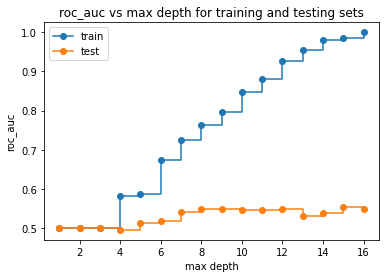

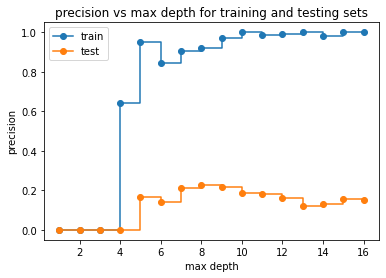

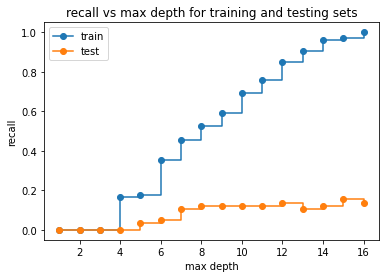

In [183]:
plt = plot_learning()
plt.savefig('./paper/figures/dt_learn_auc.png', format='png', transparent=True)
plt.show()
plt = plot_learning('precision')
plt.savefig('./paper/figures/dt_learn_precision.png', format='png', transparent=True)
plt.show()
plt = plot_learning('recall')
plt.savefig('./paper/figures/dt_learn_recall.png', format='png', transparent=True)
plt.show()

In [184]:
mins = list(range(1,18))
mse = {}
precision = {}
recall = {}
roc_auc = {}
for m in mins:
    clf = tree.DecisionTreeClassifier(min_samples_leaf=m)
    clf = clf.fit(X_train, y_train)
    pred_y_train = clf.predict(X_train)
    pred_y_test = clf.predict(X_test)
    precision[m] = precision_score(y_train, pred_y_train), precision_score(y_test, pred_y_test) 
    recall[m] = recall_score(y_train, pred_y_train), recall_score(y_test, pred_y_test) 
    roc_auc[m] = roc_auc_score(y_train, pred_y_train), roc_auc_score(y_test, pred_y_test) 
precision, recall, roc

({1: (1.0, 0.16666666666666666),
  2: (0.9436619718309859, 0.24390243902439024),
  3: (0.7804878048780488, 0.2647058823529412),
  4: (0.7611940298507462, 0.21875),
  5: (0.746031746031746, 0.20689655172413793),
  6: (0.6716417910447762, 0.13043478260869565),
  7: (0.6551724137931034, 0.05555555555555555),
  8: (0.6511627906976745, 0.16666666666666666),
  9: (0.6571428571428571, 0.18181818181818182),
  10: (0.6666666666666666, 0.25),
  11: (0.6666666666666666, 0.25),
  12: (0.75, 0.0),
  13: (0.5833333333333334, 0.0),
  14: (0.5833333333333334, 0.0),
  15: (0.5833333333333334, 0.0),
  16: (0.5833333333333334, 0.0),
  17: (0.5833333333333334, 0.0)},
 {1: (1.0, 0.15517241379310345),
  2: (0.6203703703703703, 0.1724137931034483),
  3: (0.5925925925925926, 0.15517241379310345),
  4: (0.4722222222222222, 0.1206896551724138),
  5: (0.4351851851851852, 0.10344827586206896),
  6: (0.4166666666666667, 0.05172413793103448),
  7: (0.35185185185185186, 0.017241379310344827),
  8: (0.259259259259259

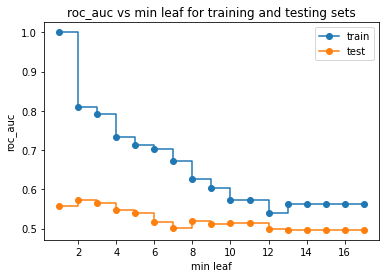

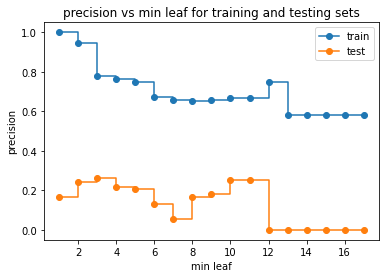

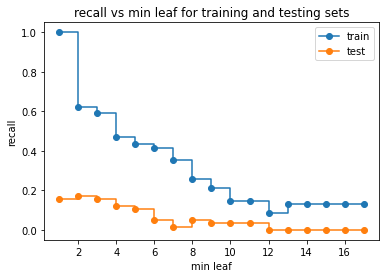

In [185]:
plt = plot_learning(x='min leaf')
plt.savefig('./paper/figures/dt_learn_auc_leaf.png', format='png', transparent=True)
plt.show()
plt = plot_learning('precision', x='min leaf')
plt.savefig('./paper/figures/dt_learn_precision_leaf.png', format='png', transparent=True)
plt.show()
plt = plot_learning('recall', x='min leaf')
plt.savefig('./paper/figures/dt_learn_recall_leaf.png', format='png', transparent=True)
plt.show()

'CART_unrestricted_2.pdf'

In [63]:
clf = tree.DecisionTreeClassifier(random_state=0, min_samples_leaf=2)
clf = clf.fit(X_train, y_train)
pred_y = clf.predict(X_train)
pred_y_test = clf.predict(X_test)
print("Node count:", clf.tree_.node_count)
print("Depth:", clf.get_depth())
print("Training precision, test precision:")
print(precision_score(y_train, pred_y), precision_score(y_test, pred_y_test))
print("Training recall, test recall:")
print(recall_score(y_train, pred_y), recall_score(y_test, pred_y_test))
print("Training roc_auc, test roc_auc:")
print(roc_auc_score(y_train, pred_y), roc_auc_score(y_test, pred_y_test))

Node count: 273
Depth: 15
Training precision, test precision:
0.9436619718309859 0.20454545454545456
Training recall, test recall:
0.6203703703703703 0.15517241379310345
Training roc_auc, test roc_auc:
0.8092698533774048 0.56126158003088


In [160]:
clf = tree.DecisionTreeClassifier(random_state=0, max_depth=8, min_samples_leaf=3)
clf = clf.fit(X_train, y_train)
pred_y = clf.predict(X_train)
pred_y_test = clf.predict(X_test)
print("Node count:", clf.tree_.node_count)
print("Depth:", clf.get_depth())
print("Leaves:", clf.get_n_leaves())
print("Avg y score test:", np.mean(pred_y_test))
print("Training precision, test precision:")
print(precision_score(y_train, pred_y), precision_score(y_test, pred_y_test))
print("Training recall, test recall:")
print(recall_score(y_train, pred_y), recall_score(y_test, pred_y_test))
print("Training roc_auc, test roc_auc:")
print(roc_auc_score(y_train, pred_y), roc_auc_score(y_test, pred_y_test))

Node count: 153
Depth: 8
Leaves: 77
Avg y score test: 0.022123893805309734
Training precision, test precision:
0.7966101694915254 0.2
Training recall, test recall:
0.4351851851851852 0.08620689655172414
Training roc_auc, test roc_auc:
0.7148465971692516 0.5337750900669068


In [172]:
depths = [11]
mse = {}
clfs = {}
best = None
best_score = -1000
for depth in range(4,16):
    for split in range(1,18):
        clf = tree.DecisionTreeClassifier(random_state=0, min_samples_leaf=split, max_depth=depth)
        clf.fit(X_train, y_train)
        if roc_auc_score(y_test, clf.predict(X_test)) > best_score:
            best_score = roc_auc_score(y_test, clf.predict(X_test))
            best = clf, depth, split

                                       
best_score

0.5740800308800824

In [173]:
clf = tree.DecisionTreeClassifier(max_depth=15, min_samples_leaf=3)
clf = clf.fit(X, y)
pred_y_val = clf.predict(X_val)
print("Training precision, test precision:")
print(precision_score(y_val, pred_y_val))
print("Training recall, test recall:")
print(recall_score(y_val, pred_y_val))
print("Training roc_auc, test roc_auc:")
print(roc_auc_score(y_val, pred_y_val))

Training precision, test precision:
0.1794871794871795
Training recall, test recall:
0.1686746987951807
Training roc_auc, test roc_auc:
0.564387224709311


## K-Nearest Neighbors

In [176]:
from sklearn.neighbors import KNeighborsClassifier


In [177]:
def return_best_model(X_train, X_test, y_train, y_test, max_k=10):

    best_model = None
    best_score = -1000
    K = [k for k in range(1,max_k)]
    weights = ['uniform', 'distance']
    
    for k in K:
        for weight in weights:
            knn = KNeighborsClassifier(n_neighbors=k, weights=weight)
            knn.fit(X_train, y_train)
            if precision_score(y_test, knn.predict(X_test)) > best_score:
                best_model = knn
                best_score = precision_score(y_test, knn.predict(X_test))
    
    return best_model, best_score
            

In [231]:
precision = {}
recall = {}
roc_auc = {}
for k in range(1,18):
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn.fit(X_train, y_train)
    pred_y_train = knn.predict(X_train)
    pred_y_test = knn.predict(X_test)
    print("Pct pos:", np.sum(pred_y_test))
    precision[k] = precision_score(y_train, pred_y_train), precision_score(y_test, pred_y_test) 
    recall[k] = recall_score(y_train, pred_y_train), recall_score(y_test, pred_y_test) 
    roc_auc[k] = roc_auc_score(y_train, pred_y_train), roc_auc_score(y_test, pred_y_test) 


Pct pos: 64
Pct pos: 10
Pct pos: 23
Pct pos: 9
Pct pos: 13
Pct pos: 9
Pct pos: 12
Pct pos: 6
Pct pos: 8
Pct pos: 0


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Pct pos: 1
Pct pos: 0


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

Pct pos: 0
Pct pos: 0


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

Pct pos: 0
Pct pos: 0
Pct pos: 0


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

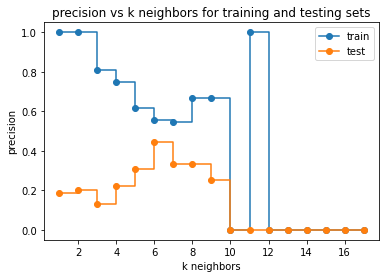

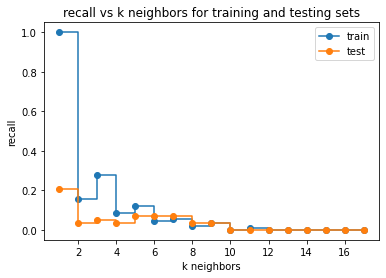

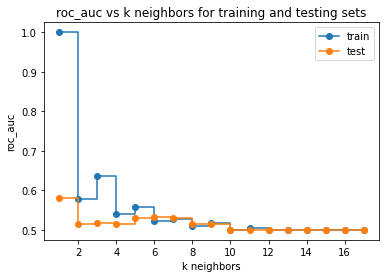

In [223]:
plt = plot_learning('precision', x = 'k neighbors')
plt.savefig('./paper/figures/knn_k_precision.png', format='png', transparent=True)
plt.show()
plt = plot_learning('recall', x = 'k neighbors')
plt.savefig('./paper/figures/knn_k_recall.png', format='png', transparent=True)
plt.show()
plt = plot_learning('roc_auc', x = 'k neighbors')
plt.savefig('./paper/figures/knn_k_auc.png', format='png', transparent=True)
plt.show()

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


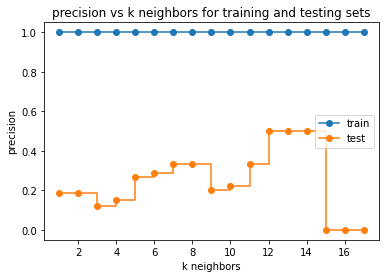

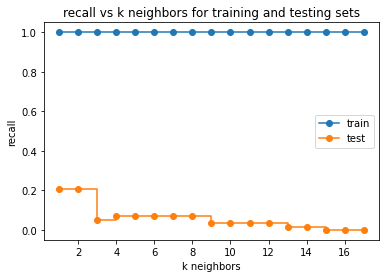

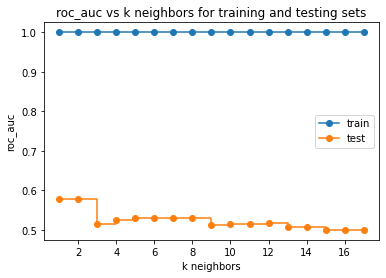

In [224]:
precision = {}
recall = {}
roc_auc = {}
for k in range(1,18):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(X_train, y_train)
    pred_y_train = knn.predict(X_train)
    pred_y_test = knn.predict(X_test)
    precision[k] = precision_score(y_train, pred_y_train), precision_score(y_test, pred_y_test) 
    recall[k] = recall_score(y_train, pred_y_train), recall_score(y_test, pred_y_test) 
    roc_auc[k] = roc_auc_score(y_train, pred_y_train), roc_auc_score(y_test, pred_y_test) 
plt = plot_learning('precision', x = 'k neighbors')
plt.savefig('./paper/figures/knn_k_precision_dist.png', format='png', transparent=True)
plt.show()
plt = plot_learning('recall', x = 'k neighbors')
plt.savefig('./paper/figures/knn_k_recall_dist.png', format='png', transparent=True)
plt.show()
plt = plot_learning('roc_auc', x = 'k neighbors')
plt.savefig('./paper/figures/knn_k_auc_dist.png', format='png', transparent=True)
plt.show()

In [238]:
knn = KNeighborsClassifier(n_neighbors=1, weights='uniform')
knn.fit(X,y)
pred_y_val = knn.predict(X_val)
print("val precision:")
print(precision_score(y_val, pred_y_val))
print("val recall:")
print(recall_score(y_val, pred_y_val))
print("val roc_auc:")
print(roc_auc_score(y_val, pred_y_val)) 
np.mean(pred_y_val)

val precision:
0.1232876712328767
val recall:
0.10843373493975904
val roc_auc:
0.5342667427816002


0.043272080616478956

In [240]:
knn = KNeighborsClassifier(n_neighbors=2, weights='distance')
knn.fit(X,y)
pred_y_val = knn.predict(X_val)
print("val precision:")
print(precision_score(y_val, pred_y_val))
print("val recall:")
print(recall_score(y_val, pred_y_val))
print("val roc_auc:")
print(roc_auc_score(y_val, pred_y_val)) 
np.mean(pred_y_val)

val precision:
0.1232876712328767
val recall:
0.10843373493975904
val roc_auc:
0.5342667427816002


0.043272080616478956

108

#### Best KNN model on a test set

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 2072020)
knn, knn_score = return_best_model(X_train, X_test, y_train, y_test, max_k=7)


In [189]:
pred_y = knn.predict(X_train)
pred_y_val = knn.predict(X_val)

print("Training precision, test precision:")
print(precision_score(y_train, pred_y), precision_score(y_val, pred_y_val))
print("Training recall, test recall:")
print(recall_score(y_train, pred_y), recall_score(y_val, pred_y_val))
print("Training roc_auc, test roc_auc:")
print(roc_auc_score(y_train, pred_y), roc_auc_score(y_val, pred_y_val))

np.mean(pred_y), np.mean(pred_y_test)

Training precision, test precision:
0.5555555555555556 0.0
Training recall, test recall:
0.046296296296296294 0.0
Training roc_auc, test roc_auc:
0.5222328163403679 0.4984413965087282


(0.0039249890972525075, 0.002963841138114997)

In [186]:
knn_score

0.4444444444444444

#### Use k-fold validation

In [243]:
from sklearn.model_selection import KFold

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
kf.get_n_splits(X)

KNNs = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    knn, knn_score = return_best_model(X_train, X_test, y_train, y_test)
    #print(knn.score(X_test, y_test))
    KNNs.append(knn)
    
preds = np.empty((y_val.shape[0], n_splits))
for i in range(n_splits):
    print(KNNs[i])
    preds[:,i] = KNNs[i].predict(X_val)
    

y_val_hat = np.mean(preds, axis=1)

r2_score(y_val, y_val_hat)





/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

KNeighborsClassifier(n_neighbors=4)
KNeighborsClassifier(n_neighbors=1)
KNeighborsClassifier(n_neighbors=2)
KNeighborsClassifier(n_neighbors=6)
KNeighborsClassifier(n_neighbors=1)


AttributeError: module 'numpy' has no attribute 'mode'

#### Maybe some feature selection on X?

In [136]:


KNNs = np.empty((n_splits, X.shape[1]))
KNN_full = np.empty((n_splits,1))
dims = list(range(X.shape[1]))
ix = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    knn, knn_score = return_best_model(X_train, X_test, y_train, y_test)
    KNN_full[ix,0] = precision_score(y_test, knn.predict(X_test))
    for i in dims:
        index = [i]
        knn, knn_score = return_best_model(X_train[:,index], X_test[:,index], y_train, y_test)
        #print(knn.score(X_test, y_test))
        KNNs[ix,i] = precision_score(y_test, knn.predict(X_test[:,index]))
    
    ix += 1
    

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

#### Find the dimensions that performed better on their own

In [137]:
colnames = ['age',
 'hypertension',
 'heart_disease',
 'avg_glucose_level',
 'bmi',
 'gender_Female',
 'gender_Other',
 'ever_married_Yes',
 'work_type_Govt_job',
 'work_type_Private',
 'work_type_Self-employed',
 'work_type_children',
 'Residence_type_Urban',
 'smoking_status_formerly smoked',
 'smoking_status_never smoked',
 'smoking_status_smokes']
chg = []

for i in range(X.shape[1]):
    chg.append(np.mean(KNN_full) - np.mean(KNNs[:,i], axis = 0))
    print(colnames[i], np.mean(KNNs[:,i], axis = 0) - np.mean(KNN_full))

age -0.2730086580086579
hypertension -0.44848484848484843
heart_disease -0.44848484848484843
avg_glucose_level -0.36701752353926265
bmi -0.1734848484848484
gender_Female -0.44848484848484843
gender_Other -0.44848484848484843
ever_married_Yes -0.44848484848484843
work_type_Govt_job -0.44848484848484843
work_type_Private -0.44848484848484843
work_type_Self-employed -0.44848484848484843
work_type_children -0.44848484848484843
Residence_type_Urban -0.44848484848484843
smoking_status_formerly smoked -0.44848484848484843
smoking_status_never smoked -0.44848484848484843
smoking_status_smokes -0.44848484848484843


#### Start with best and add features, check test data

In [138]:
import scipy.stats as ss
KNNs = []
feats = list(range(X.shape[1]))

# rank the features
ranks = ss.rankdata(chg)

tracker = {}

for ii in range(len(feats)):
    good_feats = [feats[i] for i in range(len(chg)) if ranks[i]-1 <= ii]
    scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        knn, knn_score = return_best_model(X_train[:,good_feats], X_test[:,good_feats], y_train, y_test)
        scores.append(knn_score)
        KNNs.append(knn)
    tracker[(tuple(good_feats), knn)] =  np.mean(scores)
    
tracker
    
    
    


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined a

{((4,), KNeighborsClassifier(n_neighbors=6, weights='distance')): 0.275,
 ((0, 4), KNeighborsClassifier(n_neighbors=1)): 0.5094017094017094,
 ((0, 3, 4), KNeighborsClassifier(weights='distance')): 0.42442396313364056,
 ((0, 3, 4), KNeighborsClassifier(weights='distance')): 0.42442396313364056,
 ((0, 3, 4), KNeighborsClassifier(weights='distance')): 0.42442396313364056,
 ((0, 3, 4), KNeighborsClassifier(weights='distance')): 0.42442396313364056,
 ((0, 3, 4), KNeighborsClassifier(weights='distance')): 0.42442396313364056,
 ((0, 3, 4), KNeighborsClassifier(weights='distance')): 0.42442396313364056,
 ((0, 3, 4), KNeighborsClassifier(weights='distance')): 0.42442396313364056,
 ((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15),
  KNeighborsClassifier(n_neighbors=1)): 0.44848484848484843,
 ((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15),
  KNeighborsClassifier(n_neighbors=1)): 0.44848484848484843,
 ((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15),
  KNeighborsClassifier(n

#### Only use combination of features that worked the best to score the validation data

In [139]:
best_score = -np.infty
for key, value in tracker.items():
    if value > best_score:
        feats, knn = key
        best_score = value
        
print("Best features/model:", feats, knn)


y_val_hat = knn.predict(X_val[:,list(feats)])

print("KNN performance on validation data:", r2_score(y_val, y_val_hat))

Best features/model: (0, 4) KNeighborsClassifier(n_neighbors=1)
KNN performance on validation data: -0.6473124417870988


## Artificial Neural Networks

In [249]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler  

In [304]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 2072020)

In [305]:
## Turn off warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#### Start with simple ANN

In [306]:
# scale the data
scaler = StandardScaler() 
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [290]:
def train_loop(ann, epochs):
    training_scores = np.empty((epochs, 3))
    testing_scores = np.empty((epochs, 3))
    for epoch in range(epochs):
        ann.fit(X_train, y_train)
        training_scores[epoch,:] = np.array((precision_score(y_train, ann.predict(X_train)),recall_score(y_train, ann.predict(X_train)), roc_auc_score(y_train, ann.predict(X_train))))
        testing_scores[epoch,:] = np.array((precision_score(y_test, ann.predict(X_test)), recall_score(y_test, ann.predict(X_test)), roc_auc_score(y_test, ann.predict(X_test))))
    
    print("Final train/test scores:", training_scores[-1], testing_scores[-1])
    
    return ann, training_scores, testing_scores

def plot_learning(val='precision'):
    if val == 'precision':
        ix = 0
    elif val == 'recall':
        ix = 1
    else:
        ix = 2
    epoch_list = list(range(epochs))
    fig, ax = plt.subplots()
    ax.set_xlabel("Epochs")
    ax.set_ylabel(val + " score")
    ax.set_title("Learning Curves for ANN")
    ax.plot(epoch_list, training_scores[:,ix], label="train")
    ax.plot(epoch_list, testing_scores[:,ix], label="test")
    plt.ylim((0,1))
    ax.legend()
    return plt

Final train/test scores: [0.90322581 0.77777778 0.88682939] [0.125      0.0862069  0.52677882]


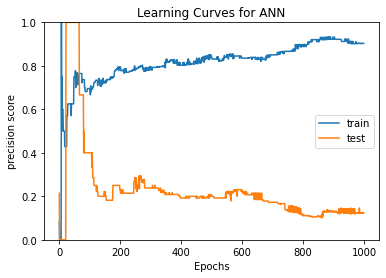

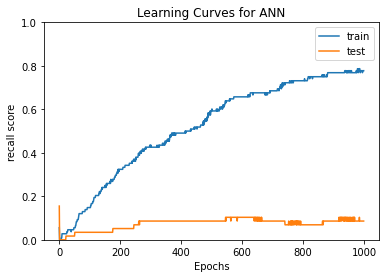

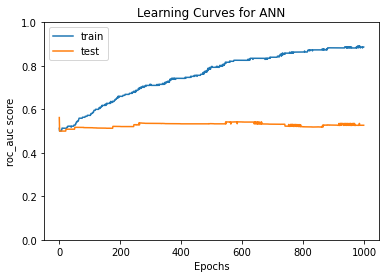

(None, None, None)

In [276]:
# initiate and train loop
epochs = 1000
params = {
    'hidden_layer_sizes':(100,),
    'activation':'relu',
    'learning_rate_init':0.001,
    'random_state':0,
    'max_iter':1,
    'warm_start':True,
         }

ann = MLPClassifier(**params)

ann, training_scores, testing_scores = train_loop(ann, epochs)
plot_learning('precision'), plot_learning('recall'), plot_learning('roc_auc')

Final train/test scores: [0.74698795 0.57407407 0.78223155] [0.125      0.0862069  0.52677882]


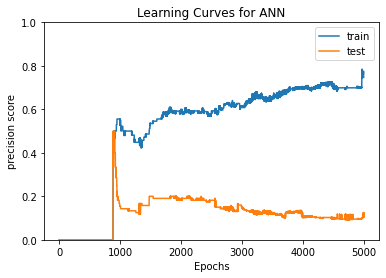

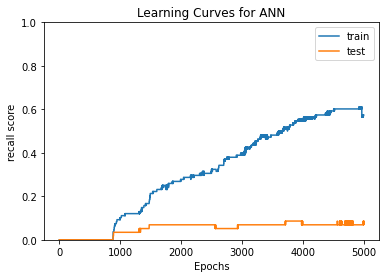

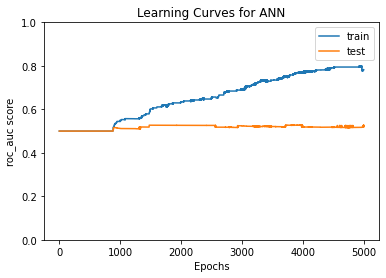

In [311]:
# initiate and train loop
epochs = 5000
params = {
    'hidden_layer_sizes':(10,10,10,10,10,10),
    'activation':'relu',
    'learning_rate_init':0.0001,
    'random_state':0,
    'max_iter':1,
    'warm_start':True,
    'alpha':0.0001,
         }

ann = MLPClassifier(**params)

ann, training_scores, testing_scores = train_loop(ann, epochs)
plt = plot_learning('precision')
plt.savefig('./paper/figures/ann_10_6_precision.png', format='png', transparent=True)
plt.show()
plt = plot_learning('recall')
plt.savefig('./paper/figures/ann_10_6_recall.png', format='png', transparent=True)
plt.show()
plt = plot_learning('roc_auc')
plt.savefig('./paper/figures/ann_10_6_roc_auc.png', format='png', transparent=True)
plt.show()

In [294]:
# initiate and train loop
epochs = 5000
params = {
    'hidden_layer_sizes':(100,100,100),
    'activation':'relu',
    'learning_rate_init':0.0001,
    'random_state':0,
    'max_iter':1,
    'warm_start':True,
    'alpha':0.0001,
         }

ann = MLPClassifier(**params)

ann, training_scores, testing_scores = train_loop(ann, epochs)

Final train/test scores: [1. 1. 1.] [0.08064516 0.0862069  0.51651763]


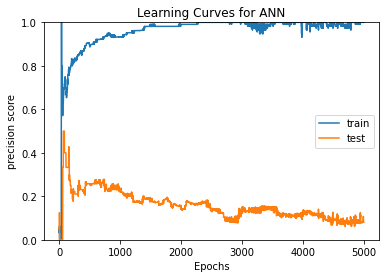

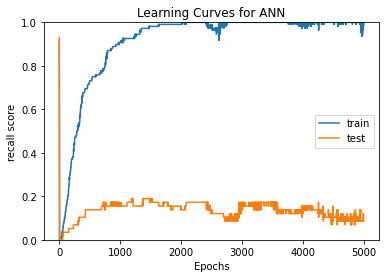

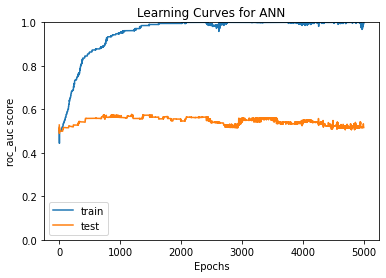

In [295]:
plt = plot_learning('precision')
plt.savefig('./paper/figures/ann_100_3_precision.png', format='png', transparent=True)
plt.show()
plt = plot_learning('recall')
plt.savefig('./paper/figures/ann_100_3_recall.png', format='png', transparent=True)
plt.show()
plt = plot_learning('roc_auc')
plt.savefig('./paper/figures/ann_100_3_roc_auc.png', format='png', transparent=True)
plt.show()

In [315]:
# initiate and train loop
epochs = 700
params = {
    'hidden_layer_sizes':(100,100,100),
    'activation':'relu',
    'learning_rate_init':0.0001,
    'random_state':0,
    'max_iter':1,
    'warm_start':True,
    'alpha':0.0001,
         }

ann = MLPClassifier(**params)

ann, training_scores, testing_scores = train_loop(ann, epochs)

Final train/test scores: [0.92307692 0.77777778 0.88728706] [0.26470588 0.15517241 0.56592576]


(<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>,
 <module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>,
 <module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>)

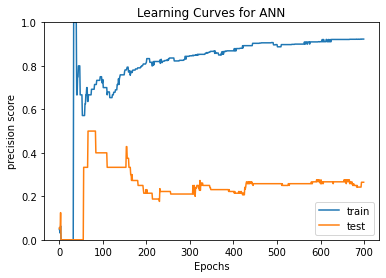

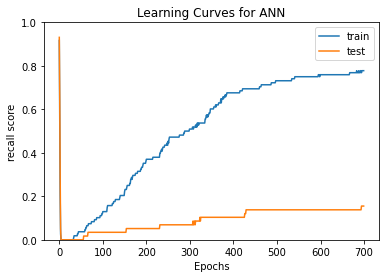

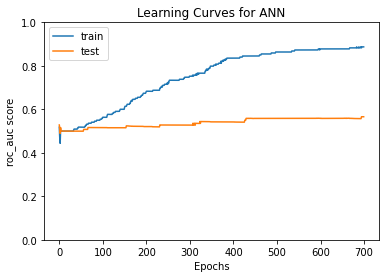

In [316]:
plot_learning('precision'), plot_learning('recall'), plot_learning('roc_auc')

In [317]:
precision_score(y_val, ann.predict(X_val_scaled)), recall_score(y_val, ann.predict(X_val_scaled)), roc_auc_score(y_val, ann.predict(X_val_scaled))

(0.0847457627118644, 0.060240963855421686, 0.5132875642219753)

Final train/test scores: [0.90756303 1.         0.99748284] [0.15492958 0.18965517 0.56684251]


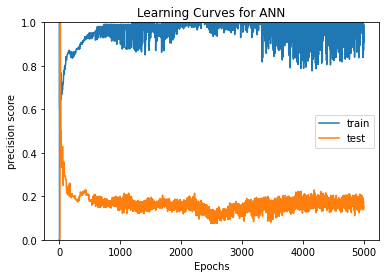

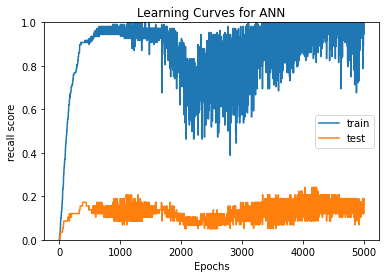

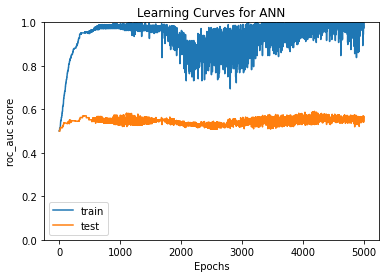

In [312]:
# initiate and train loop
epochs = 5000
params = {
    'hidden_layer_sizes':(1000,1000),
    'activation':'relu',
    'learning_rate_init':0.0001,
    'random_state':0,
    'max_iter':1,
    'warm_start':True,
    'alpha':0.001,
         }

ann = MLPClassifier(**params)

ann, training_scores, testing_scores = train_loop(ann, epochs)
plt = plot_learning('precision')
plt.savefig('./paper/figures/ann_1000_2_precision.png', format='png', transparent=True)
plt.show()
plt = plot_learning('recall')
plt.savefig('./paper/figures/ann_1000_2_recall.png', format='png', transparent=True)
plt.show()
plt = plot_learning('roc_auc')
plt.savefig('./paper/figures/ann_1000_2_roc_auc.png', format='png', transparent=True)
plt.show()

In [314]:
precision_score(y_val, ann.predict(X_val_scaled)), recall_score(y_val, ann.predict(X_val_scaled)), roc_auc_score(y_val, ann.predict(X_val_scaled))

(0.08823529411764706, 0.10843373493975904, 0.5252268425322237)

## Boosting

In [60]:
from sklearn.ensemble import GradientBoostingClassifier

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 2072020)

In [62]:
params = {
    "n_estimators": 10000,
    "max_depth": 3,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "log_loss",
}

reg = GradientBoostingClassifier(**params).fit(X_train, y_train)
reg.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, min_samples_split=5,
                           n_estimators=10000)

In [424]:
test_score_precision = np.zeros((params["n_estimators"],), dtype=np.float64)
test_score_recall = np.zeros((params["n_estimators"],), dtype=np.float64)
test_score_roc_auc = np.zeros((params["n_estimators"],), dtype=np.float64)
train_score_precision = np.zeros((params["n_estimators"],), dtype=np.float64)
train_score_recall = np.zeros((params["n_estimators"],), dtype=np.float64)
train_score_roc_auc = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score_precision[i] = precision_score(y_test, y_pred)
    test_score_recall[i] = recall_score(y_test, y_pred)
    test_score_roc_auc[i] = roc_auc_score(y_test, y_pred)
for i, y_pred in enumerate(reg.staged_predict(X_train)):
    train_score_precision[i] = precision_score(y_train, y_pred)
    train_score_recall[i] = recall_score(y_train, y_pred)
    train_score_roc_auc[i] = roc_auc_score(y_train, y_pred)

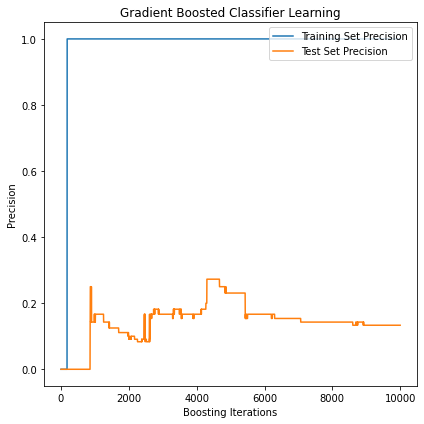

In [425]:
    
fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Gradient Boosted Classifier Learning")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    train_score_precision,
    label="Training Set Precision",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score_precision, label="Test Set Precision"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Precision")
fig.tight_layout()
plt.savefig('./paper/figures/boost_precision.png', format='png', transparent=True)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

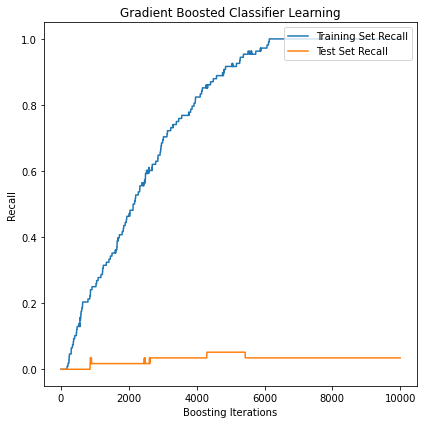

In [426]:

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Gradient Boosted Classifier Learning")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    train_score_recall,
    label="Training Set Recall",
)
plt.plot(np.arange(params["n_estimators"]) + 1, test_score_recall, label="Test Set Recall"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Recall")
fig.tight_layout()
plt.savefig('./paper/figures/boost_recall.png', format='png', transparent=True)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

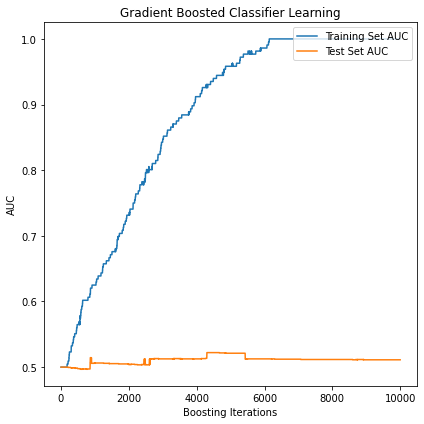

In [427]:

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Gradient Boosted Classifier Learning")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    train_score_roc_auc,
    label="Training Set AUC",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score_roc_auc, label="Test Set AUC"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("AUC")
fig.tight_layout()
plt.savefig('./paper/figures/boost_auc.png', format='png', transparent=True)
plt.show

In [428]:
precision_score(y_test, reg.predict(X_test)), recall_score(y_test, reg.predict(X_test)), roc_auc_score(y_test, reg.predict(X_test))


(0.13333333333333333, 0.034482758620689655, 0.511177946474524)

In [63]:
params = {
    "n_estimators": 5000,
    "max_depth": 3,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "log_loss",
}

reg = GradientBoostingClassifier(**params).fit(X_train, y_train)
reg.fit(X_train, y_train)

precision_score(y_val, reg.predict(X_val)), recall_score(y_val, reg.predict(X_val)), roc_auc_score(y_val, reg.predict(X_val))

(0.058823529411764705, 0.012048192771084338, 0.5010365652134723)

### Support Vector Machines

In [8]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler  

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 2072020)

In [10]:
# scale the data
scaler = StandardScaler() 
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)
X_scaled = scaler.transform(X)

In [42]:

params = {'kernel':'poly', 'degree':5, 'C':1000,'gamma':'auto'}

clf = svm.SVC(**params)

clf.fit(X_train, y_train)
pred_y = clf.predict(X_train)
pred_y_test = clf.predict(X_test)
print("Training precision, test precision:")
print(precision_score(y_train, pred_y), precision_score(y_test, pred_y_test))
print("Training recall, test recall:")
print(recall_score(y_train, pred_y), recall_score(y_test, pred_y_test))
print("Training roc_auc, test roc_auc:")
print(roc_auc_score(y_train, pred_y), roc_auc_score(y_test, pred_y_test))

Training precision, test precision:
1.0 0.15789473684210525
Training recall, test recall:
0.8518518518518519 0.20689655172413793
Training roc_auc, test roc_auc:
0.9259259259259259 0.5735975295934123


In [33]:

params = {'kernel':'rbf', 'C':1000,'gamma':'auto'}

clf = svm.SVC(**params)

clf.fit(X_train, y_train)
pred_y = clf.predict(X_train)
pred_y_test = clf.predict(X_test)
print("Training precision, test precision:")
print(precision_score(y_train, pred_y), precision_score(y_test, pred_y_test))
print("Training recall, test recall:")
print(recall_score(y_train, pred_y), recall_score(y_test, pred_y_test))
print("Training roc_auc, test roc_auc:")
print(roc_auc_score(y_train, pred_y), roc_auc_score(y_test, pred_y_test))

Training precision, test precision:
1.0 0.125
Training recall, test recall:
0.7962962962962963 0.1206896551724138
Training roc_auc, test roc_auc:
0.8981481481481481 0.5374903499742666


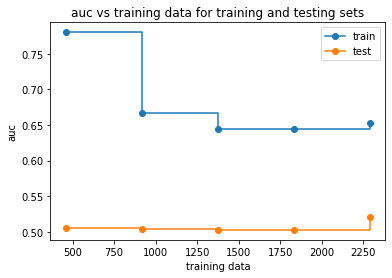

In [55]:
params = {'kernel':'poly','degree':5, 'C':1,'gamma':'auto'}


n_splits = 5
n = X_train.shape[0] // n_splits
ind = [i*n for i in range(5)]
ind.reverse()
auc = {}
for i in range(n_splits):
    ix = [j >= ind[i] for j in range(X_train.shape[0])]
    X_train_i = X_train[ix]
    y_train_i = y_train[ix]
    clf = svm.SVC(**params)
    clf.fit(X_train_i, y_train_i)
    pred_y_test = clf.predict(X_test)
    pred_y_i = clf.predict(X_train_i)
    auc[ind[i]+n] = roc_auc_score(y_train_i, pred_y_i), roc_auc_score(y_test, pred_y_test) 
plt = plot_learning('auc',x='training data')
plt.savefig('./paper/figures/svc_learn_auc_data.png', format='png', transparent=True)
plt.show()

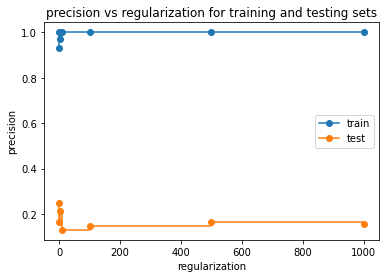

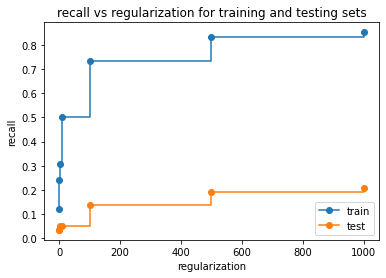

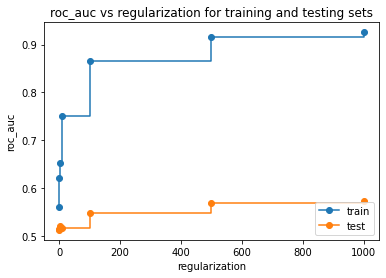

In [56]:


precision = {}
recall = {}
roc_auc = {}
for k in [0.1,0.5,1,10,100,500,1000]:
    params = {'kernel':'poly','degree':5, 'C':k,'gamma':'auto'}
    clf = svm.SVC(**params)
    clf.fit(X_train, y_train)
    pred_y_train = clf.predict(X_train)
    pred_y_test = clf.predict(X_test)
    precision[k] = precision_score(y_train, pred_y_train), precision_score(y_test, pred_y_test) 
    recall[k] = recall_score(y_train, pred_y_train), recall_score(y_test, pred_y_test) 
    roc_auc[k] = roc_auc_score(y_train, pred_y_train), roc_auc_score(y_test, pred_y_test) 

plt = plot_learning('precision', x = 'regularization')
plt.savefig('./paper/figures/svc_precision_c.png', format='png', transparent=True)
plt.show()
plt = plot_learning('recall', x = 'regularization')
plt.savefig('./paper/figures/svc_recall_c.png', format='png', transparent=True)
plt.show()
plt = plot_learning('roc_auc', x = 'regularization')
plt.savefig('./paper/figures/svc_roc_auc_c.png', format='png', transparent=True)
plt.show()

In [57]:
pred_y = clf.predict(X_train)
pred_y_test = clf.predict(X_test)
pred_y_val = clf.predict(X_val_scaled)
print("Training precision, test precision:")
print(precision_score(y_train, pred_y), precision_score(y_test, pred_y_test), precision_score(y_val, pred_y_val))
print("Training recall, test recall:")
print(recall_score(y_train, pred_y), recall_score(y_test, pred_y_test), recall_score(y_val, pred_y_val))
print("Training roc_auc, test roc_auc:")
print(roc_auc_score(y_train, pred_y), roc_auc_score(y_test, pred_y_test), roc_auc_score(y_val, pred_y_val))

Training precision, test precision:
1.0 0.15789473684210525 0.1
Training recall, test recall:
0.8518518518518519 0.20689655172413793 0.10843373493975904
Training roc_auc, test roc_auc:
0.9259259259259259 0.5735975295934123 0.528967490911276


In [ ]:
scaler = StandardScaler() 
scaler.fit(X)
X_scaled = scaler.transform(X)

parameters = {'kernel':('linear', 'rbf','poly'), 'C':[1, 10, 100],'gamma':('auto','scale'),
             'epsilon':[0.001,.01,.1,.5]}

reg = svm.SVR()
clf = GridSearchCV(reg, parameters)
clf.fit(X_scaled, y)
sorted(clf.cv_results_.keys())

In [17]:
clf.cv_results_

{'mean_fit_time': array([0.18502107, 0.25257459, 0.19444146, 0.17775245, 0.25251274,
        0.19331222, 0.17833176, 0.26266022, 0.1937191 , 0.18710718,
        0.25400577, 0.20184746, 0.17828345, 0.25160379, 0.19622121,
        0.17779784, 0.25221386, 0.1944828 , 0.17883067, 0.25269561,
        0.19437022, 0.17980499, 0.25381756, 0.19380398, 0.17720723,
        0.25232153, 0.19416037, 0.1762527 , 0.25306969, 0.19448032,
        0.17666373, 0.25101705, 0.19492083, 0.17517142, 0.25222926,
        0.19525485, 0.17651024, 0.25301552, 0.19514055, 0.18131022,
        0.25709424, 0.1954566 , 0.17603683, 0.25416985, 0.19447913,
        0.17541394, 0.25647297, 0.19854765, 0.17684312, 0.25673037,
        0.20348306, 0.17632356, 0.25637636, 0.20649557, 0.17515903,
        0.25184398, 0.19715724, 0.17405486, 0.25430841, 0.19689741,
        0.17509093, 0.25291872, 0.19734101, 0.17418828, 0.25397153,
        0.2005559 , 0.17415109, 0.25213118, 0.1977428 , 0.17213244,
        0.25245023, 0.19697118]